# Imports

In [1]:
# Planetary computer Search
from pystac_client import Client
import planetary_computer as pc

# DataFrames - Read and Write
import pandas as pd
import numpy as np
import geopandas as gpd

# Raster Operations
import rioxarray as rxr
from xrspatial.zonal import stats

# Raster Visualization (xArray can be used but computation heavy) 
import rasterio
from rasterio import windows
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

# Load Boundary data

In [2]:
def set_projection(geo_df, projection=4326):
    current_crs = geo_df.crs 
    if current_crs == projection :
        return geo_df 
    else : 
        geo_df = geo_df.to_crs(projection)
        return geo_df

In [3]:
delhi_subdistricts = gpd.read_file('delhi.gpkg')
delhi_subdistricts = set_projection(delhi_subdistricts, 4326)

In [4]:
# set this as defalt CRS, this CRS will be used for all data
def_crs = delhi_subdistricts.crs
def_crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [5]:
# get bounding box around delhi region. 
# This values will be ised to query the Planetary computer data catalog
delhi = delhi_subdistricts.dissolve()
bounds_df = delhi.bounds.squeeze()
bounds = [bounds_df['minx'], bounds_df['miny'], bounds_df['maxx'], bounds_df['maxy']]
bounds

[76.83967590307624, 28.404384613020298, 77.34802246082981, 28.883295059185293]

# Query for Landcover (raster)

In [6]:
catalog = Client.open("https://planetarycomputer.microsoft.com/api/stac/v1")

search = catalog.search(collections=["esa-worldcover"], bbox=bounds)

items = list(search.get_items())
print(f"Returned {len(items)} Items")

/srv/conda/envs/notebook/lib/python3.11/site-packages/pystac_client/item_search.py:826: FutureWarning: get_items() is deprecated, use items() instead
  warnings.warn(


Returned 2 Items


In [7]:
items

[<Item id=ESA_WorldCover_10m_2021_v200_N27E075>,
 <Item id=ESA_WorldCover_10m_2020_v100_N27E075>]

In [8]:
asset_href = items[0].assets["map"].href
print(asset_href)

https://ai4edataeuwest.blob.core.windows.net/esa-worldcover/v200/2021/map/ESA_WorldCover_10m_2021_v200_N27E075_Map.tif


In [9]:
signed_href = pc.sign(asset_href)
signed_href

'https://ai4edataeuwest.blob.core.windows.net/esa-worldcover/v200/2021/map/ESA_WorldCover_10m_2021_v200_N27E075_Map.tif?st=2023-10-28T13%3A25%3A20Z&se=2023-11-05T13%3A25%3A20Z&sp=rl&sv=2021-06-08&sr=c&skoid=c85c15d6-d1ae-42d4-af60-e2ca0f81359b&sktid=72f988bf-86f1-41af-91ab-2d7cd011db47&skt=2023-10-29T13%3A25%3A19Z&ske=2023-11-05T13%3A25%3A19Z&sks=b&skv=2021-06-08&sig=JpBSR3O/jklgOv08QbKlkOzjxxg91KXutNHjJXvi%2BEc%3D'

# Landcover visualization 

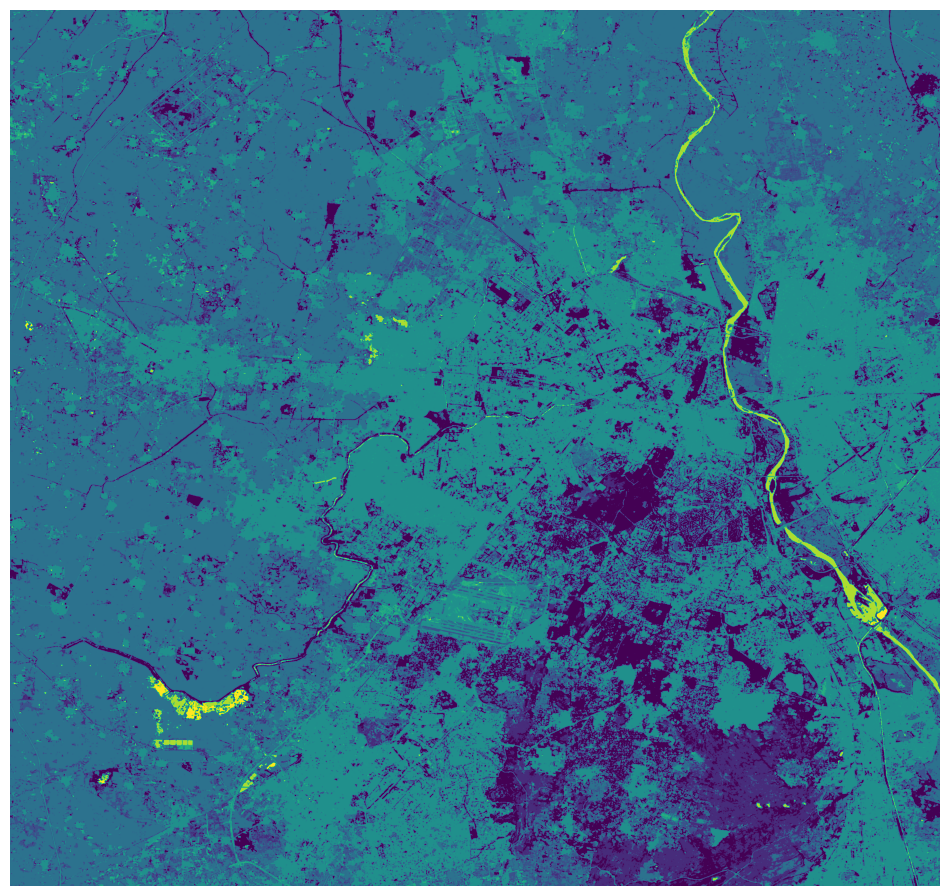

In [10]:
with rasterio.open(signed_href) as src:
    aoi_window = windows.from_bounds(transform=src.transform, *bounds)
    raster_data = src.read(1, window=aoi_window)

fig, ax = plt.subplots(figsize=(12, 12))

ax.set_axis_off()
ax.imshow(raster_data);

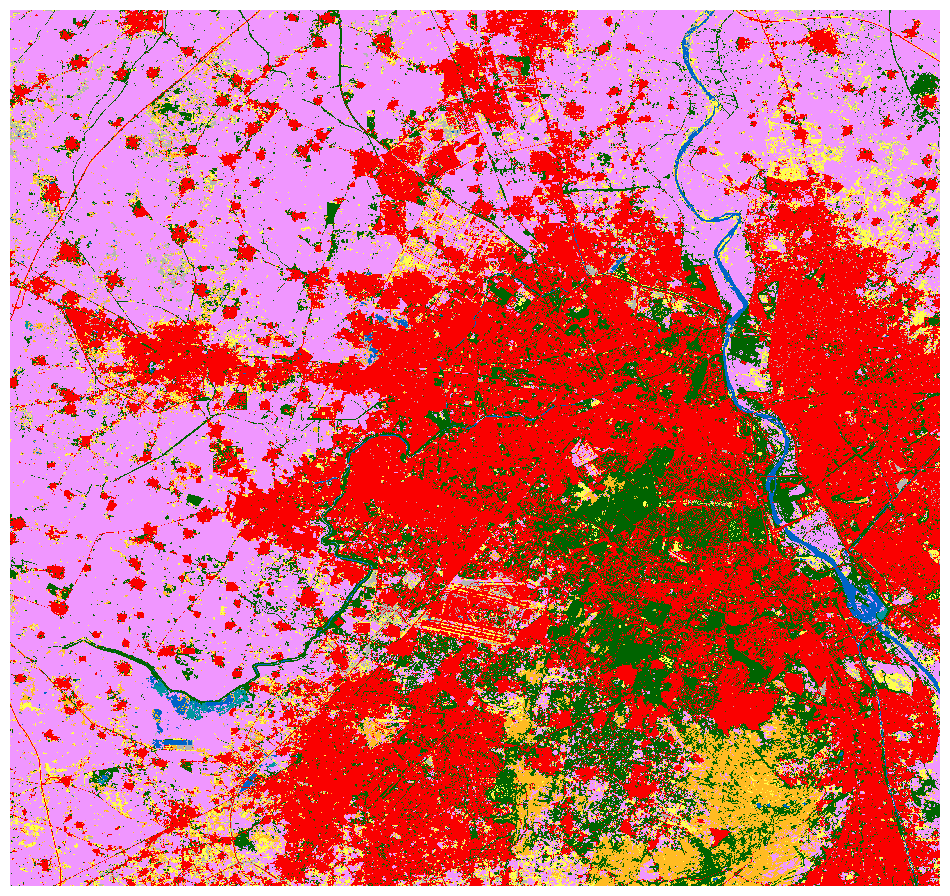

In [11]:
with rasterio.open(signed_href) as src:
    colormap_def = src.colormap(1)
    colormap = [np.array(colormap_def[i]) / 255 for i in range(len(colormap_def))]

cmap = ListedColormap(colormap)
fig, ax = plt.subplots(figsize=(12, 12))

ax.set_axis_off()
ax.imshow(raster_data, cmap=cmap, vmin=0,  vmax=(len(colormap_def) - 1),  interpolation="nearest");

# Converting to xArray DataFrame for computation

In [12]:
delhi_landcover = rxr.open_rasterio(signed_href)
delhi_landcover

<xarray.DataArray (band: 1, y: 36000, x: 36000)>
[1296000000 values with dtype=uint8]
Coordinates:
  * band         (band) int64 1
  * x            (x) float64 75.0 75.0 75.0 75.0 75.0 ... 78.0 78.0 78.0 78.0
  * y            (y) float64 30.0 30.0 30.0 30.0 30.0 ... 27.0 27.0 27.0 27.0
    spatial_ref  int64 0
Attributes: (12/18)
    algorithm_version:  V2.0.0
    AREA_OR_POINT:      Area
    copyright:          ESA WorldCover project 2021 / Contains modified Coper...
    creation_time:      2022-10-21 07:35:40.236136
    legend:             10  Tree cover\n20  Shrubland\n30  Grassland\n40  Cro...
    license:            CC-BY 4.0 - https://creativecommons.org/licenses/by/4.0/
    ...                 ...
    time_end:           2021-12-31T23:59:59Z
    time_start:         2021-01-01T00:00:00Z
    title:              ESA WorldCover product at 10m resolution for year 2021
    _FillValue:         0
    scale_factor:       1.0
    add_offset:         0.0

In [13]:
delhi_landcover_clipped = delhi_landcover.rio.clip(delhi.geometry.values, def_crs)

In [14]:
# delhi_landcover_clipped.rio.to_raster("delhi_landcover_clipped.tif")

# Landcover area computation. 

Area should be in metric units, so we have to re-project our data's to any Projected coordinate system. 

``EPSG:32643``  is a good option since we are working in delhi region falls in UTM 43N. Lets re-project our data to this CRS

In [15]:
delhi_landcover_clipped.rio.crs

CRS.from_epsg(4326)

In [16]:
# Reproject boundary file and get 32643 WRK File 
delhi_subdistricts_projected = set_projection(delhi_subdistricts, 32643)
reproject_crs = delhi_subdistricts_projected.crs
print(reproject_crs)
# To get the pixel resolution
delhi_landcover_clipped_projected = delhi_landcover_clipped.rio.reproject(reproject_crs)

EPSG:32643


In [17]:
# Compute the Pixel size to compute ara 
x_res = abs(delhi_landcover_clipped_projected.rio.resolution()[0])
y_res = abs(delhi_landcover_clipped_projected.rio.resolution()[1])
print(x_res, y_res)

8.677247770294063 8.677247770294063


In [18]:
delhi_subdistricts_projected

,SID,NAME,DISTRICT,geometry
0,07,Seelam Pur,3,"MULTIPOLYGON (((716562.595 3186214.578, 716845..."
1,07,Saraswati Vihar,1,"MULTIPOLYGON (((690660.769 3185996.894, 690683..."
2,07,Najafgarh,8,"MULTIPOLYGON (((690971.751 3172713.657, 691021..."
3,07,Gandhi Nagar,4,"MULTIPOLYGON (((721749.373 3173099.479, 721788..."
4,07,Patel Nagar,7,"MULTIPOLYGON (((698148.197 3168542.380, 698244..."
5,07,Rajouri Garden,7,"MULTIPOLYGON (((707059.929 3173160.440, 707153..."
6,07,Sadar Bazar,2,"MULTIPOLYGON (((719336.438 3174616.631, 719336..."
7,07,Shahdara,3,"MULTIPOLYGON (((723886.136 3176478.465, 723864..."
8,07,Vivek Vihar,4,"MULTIPOLYGON (((724299.293 3173883.747, 725641..."
9,07,Patel Nagar,7,"MULTIPOLYGON (((710733.480 3174008.408, 711081..."


In [19]:
concatList = []
for _, sub_district in delhi_subdistricts_projected.iterrows():
    shape_geom = sub_district['geometry'].geoms
    raster = delhi_landcover_clipped_projected.rio.clip(shape_geom, reproject_crs)
    stats_df = stats(zones=raster[0], values=raster[0])
    stats_df['area_km'] = stats_df['count']*x_res*y_res/1000000
    stats_df['area_km'] = stats_df['area_km'].round(decimals= 2)
    stats_df = stats_df[['zone', 'area_km']].set_index('zone').drop(0).transpose()
    stats_df['sub_district'] = sub_district['NAME']
    concatList.append(stats_df)
area_df = pd.concat(concatList)
area_df = area_df.set_index('sub_district')

In [20]:
calss_values = {
  10: "Trees",
  20: "Shrubland",
  30: "Grassland",
  40: "Cropland",
  50: "Built-up",
  60: "Barren / sparse vegetation",
  70: "Snow and ice",
  80: "Open water",
  90: "Herbaceous wetland",
  95: "Mangroves",
  100: "Moss and lichen"
}

In [21]:
area_df = area_df.rename(columns=calss_values).sort_index()
area_df.head()

zone,Trees,Shrubland,Grassland,Cropland,Built-up,Barren / sparse vegetation,Open water,Herbaceous wetland
sub_district,,,,,,,,
Chanakya Puri,12.18,0.03,0.69,0.15,6.76,0.06,0.00,NaN
Civil Lines,12.49,0.36,2.44,15.23,24.73,1.08,2.84,0.00
Connaught Place,6.64,0.01,0.21,0.26,5.53,0.12,0.54,NaN
Darya Ganj,2.91,0.01,0.18,0.62,4.07,0.07,0.35,0.00
Defence Colony,14.57,0.16,1.59,3.98,26.42,0.58,3.98,0.11


# Export the csv file with area value for each category

In [21]:
area_df.to_csv('delhi_landcover_area_sqkm_pccompute.csv')